In [1]:
import jax
from jax import grad, jit, vmap
from jax import numpy as jnp
from jax.numpy import array
from jax.scipy.special import erf
import numpy as np
from numpy.random import random
from time import perf_counter
from math import pi
from matplotlib import pyplot as plt
from scipy import optimize
import networkx as nx
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)

# set periodic box, spacing
L_x, L_y = 100, 100
spacing = 5
alpha = min(L_x, L_y) / 4

In [2]:
"""Precompute Numerical Fourier Transform of Interlayer Potential"""

# get rectangular grid of wavevectors
alpha = min(L_x, L_y) / 4 # short range negligible beyond one unit cell
n_x, n_y = int((4 / pi) * (L_x / alpha)), int((4 / pi) * (L_y / alpha)) # acceptable convergence
k_x, k_y = jnp.reshape(jnp.mgrid[-n_x:n_x + 1, -n_y:n_y + 1], (2, (2 * n_x + 1) * (2 * n_y + 1)))
k_x, k_y = (2 * pi / L_x) * k_x, (2 * pi / L_y) * k_y

# analytically compute FT of the long-range intralayer potential (exact expression known)
k = jnp.sqrt(k_x ** 2 + k_y ** 2)
cutoff = 1 - erf(k * alpha / 2)
v_intralayer_k = cutoff * (2 * pi) / k
v_intralayer_k = v_intralayer_k.at[len(v_intralayer_k) // 2].set(0) # cut out divergence (charge neutrality / screening)

# numerically compute FT of the long-range interlayer potential (not analytical, must integrate numerically)
s = 8 * alpha # beyond this
n = 2000 # number of grid points in one direction
dA = (2 * s) ** 2 / n ** 2 # area element
x_grid, y_grid = ((jnp.mgrid[0:n, 0:n] * 2 / n - 1) * s).reshape(2, n ** 2)
r_grid = jnp.sqrt(x_grid ** 2 + y_grid ** 2)
v_grid = erf(r_grid / alpha) / jnp.sqrt(r_grid ** 2 + spacing ** 2)
wave = jnp.exp(-1j * (jnp.outer(x_grid, k_x) + jnp.outer(y_grid, k_y)))
v_interlayer_k = v_grid @ wave * dA

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
"""Intralayer Interactions"""

# short-range interaction between particles located at (x, y) in the same plane
# strictly speaking, we ignored the background, but it is just a position-independent finite constant
@jit
def intralayer_short_range(x, y):
    # make everything modulo the periodic box
    x = x % L_x
    y = y % L_y
    
    # get all interactions in a square around the unit cell
    width = 1 # how many neighboring unit cells to include in the short-range sum
    n_x, n_y = jnp.reshape(jnp.mgrid[-width:width + 1, -width:width + 1], (2, (2 * width + 1) ** 2))
    x_prime = (jnp.outer(x, jnp.ones(len(n_x))) + L_x * jnp.outer(jnp.ones(len(x)), n_x)).flatten()
    y_prime = (jnp.outer(y, jnp.ones(len(n_y))) + L_y * jnp.outer(jnp.ones(len(y)), n_y)).flatten()
    
    # compute all displacements
    d_x = jnp.outer(x, jnp.ones(len(x_prime))) - jnp.outer(jnp.ones(len(x)), x_prime)
    d_y = jnp.outer(y, jnp.ones(len(y_prime))) - jnp.outer(jnp.ones(len(y)), y_prime)
    dr_squared = jnp.sort((d_x ** 2 + d_y ** 2).flatten())
               
    # cut out the self-energy BEFORE square root (otherwise jax's grad will produce infinity)
    dr_squared = dr_squared.at[:len(x)].set(1e10)
    dr = jnp.sqrt(dr_squared)
    potentials = (1 / 2) * (1 - erf(dr / alpha)) / dr # REMEMBER THE HALF
    return(jnp.sum(potentials))

# long-range interaction between particles located at (x, y) in the same plane
# strictly speaking, we ignored the self-energy, but this is just a position-independent finite constant
@jit
def intralayer_long_range(x, y):
    # make everything modulo the periodic box
    x = x % L_x
    y = y % L_y
    
    # use Fourier energy expression
    rho_k = jnp.sum(jnp.exp(-1j * (jnp.outer(k_x, x) + jnp.outer(k_y, y))), axis=1)
    energy = (1 / (2 * L_x * L_y)) * (jnp.sum(rho_k * rho_k.conj() * v_intralayer_k))
    energy = energy.real # explicitly remove spurious small imaginary part
    return(energy)

# bring it all together, make the single layer's ground state is a triangular lattice
def intralayer_energy(positions):
    # unpack unified input
    x, y = positions[:len(positions) // 2], positions[len(positions) // 2:]
    energy = intralayer_short_range(x, y) + intralayer_long_range(x, y)
    return(energy)
intralayer_gradient = grad(intralayer_energy)

In [4]:
"""Interlayer Interactions"""

# interlayer potential is convergent in k-space (finite as r -> 0), do everything in reciprocal space
@jit
def interlayer_short_range(x1, y1, x2, y2):
    # make everything modulo the periodic box
    x1 = x1 % L_x
    y1 = y1 % L_y
    x2 = x2 % L_x
    y2 = y2 % L_y
    
    # get all interactions in a square around the unit cell ()
    width = 1 # how many neighbors
    n_x, n_y = jnp.reshape(jnp.mgrid[-width:width + 1, -width:width + 1], (2, (2 * width + 1) ** 2))
    x2_prime = (jnp.outer(x2, jnp.ones(len(n_x))) + L_x * jnp.outer(jnp.ones(len(x2)), n_x)).flatten()
    y2_prime = (jnp.outer(y2, jnp.ones(len(n_y))) + L_y * jnp.outer(jnp.ones(len(y2)), n_y)).flatten()
    
    # compute all displacements
    d_x = (jnp.outer(x1, jnp.ones(len(x2_prime))) - jnp.outer(jnp.ones(len(x1)), x2_prime))
    d_y = (jnp.outer(y1, jnp.ones(len(y2_prime))) - jnp.outer(jnp.ones(len(y1)), y2_prime))
    dr = jnp.sqrt(d_x ** 2 + d_y ** 2 + spacing ** 2)
    potentials = (1 - erf(dr / alpha)) / dr # NO HALF, REMEMBER THE SHORT RANGE!
    return(jnp.sum(potentials))

# precompute fourier transform of interlayer potential
@jit
def interlayer_long_range(x1, y1, x2, y2):
    # make everything modulo the periodic box
    x1 = x1 % L_x
    y1 = y1 % L_y
    x2 = x2 % L_x
    y2 = y2 % L_y
    
    # use Fourier energy expression
    rho1_k = jnp.sum(jnp.exp(-1j * (jnp.outer(k_x, x1) + jnp.outer(k_y, y1))), axis=1)
    rho2_k = jnp.sum(jnp.exp(-1j * (jnp.outer(k_x, x2) + jnp.outer(k_y, y2))), axis=1)
    energy = (1 / (2 * L_x * L_y)) * jnp.sum(jnp.sum(rho1_k * rho2_k.conj() * v_interlayer_k))
    energy = energy.real # explicitly remove imaginary part
    return(energy)

In [5]:
"""Unify to Study Bilayer"""

# add up all contributions
@jit
def bilayer(x1, y1, x2, y2):
    # compute intralayer energy for layer 1 and 2
    intralayer_1 = intralayer_short_range(x1, y1) + intralayer_long_range(x1, y1)
    intralayer_2 = intralayer_short_range(x2, y2) + intralayer_long_range(x2, y2)
                                                                          
    # compute interlayer energy (remember to add the sign)
    interlayer = interlayer_short_range(x1, y1, x2, y2) + interlayer_long_range(x1, y1, x2, y2)
    return(intralayer_1 + intralayer_2 - interlayer)

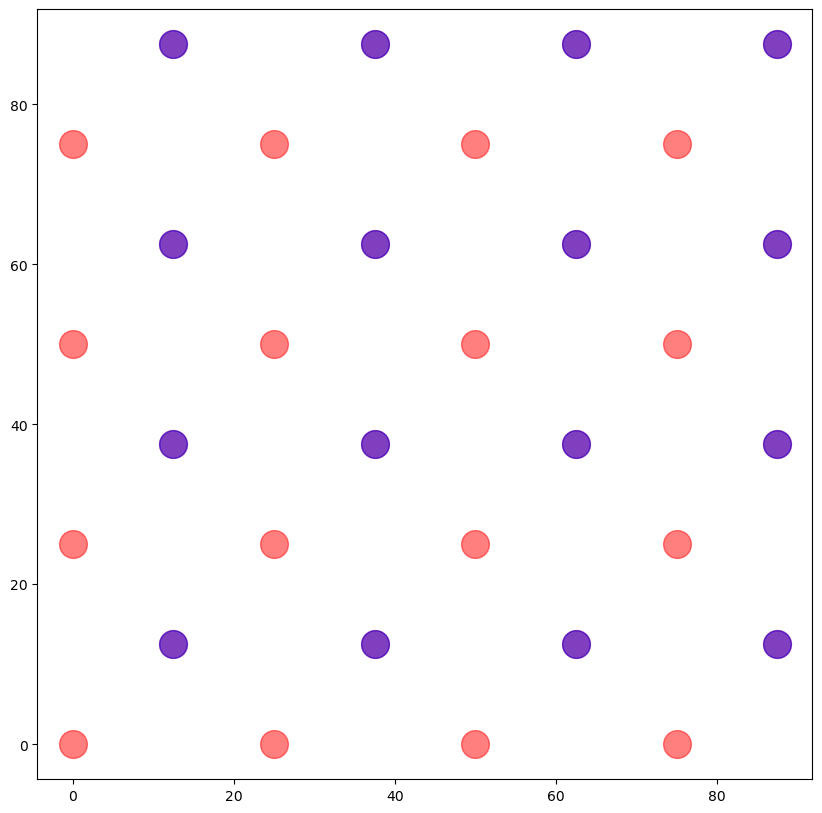

In [6]:
"""Initialize Square Exciton Geometry"""

# create square lattice
N_x = 4
N_y = 4
model = nx.Graph()
positions = [n_x * array([1 / N_x, 0]) + n_y * array([0, 1 / N_y]) for (n_x, n_y) in np.ndindex(N_x, N_y)]
for index in range(len(positions)):
    model.add_node(index, pos=positions[index])

# create the checkerboard
x_black = L_x * array([position[0] for position in positions])
y_black = L_y * array([position[1] for position in positions])
x_white = x_black + (1 / 2) * (L_x / N_x)
y_white = y_black + (1 / 2) * (L_y / N_y)

# create electron and hole ositions
x_electron = jnp.concatenate((x_black, x_white))
y_electron = jnp.concatenate((y_black, y_white))
x_hole = x_white.copy()
y_hole = y_white.copy()

# visualize for confirmation
plt.figure(figsize=(10, 10))
plt.scatter(x_electron, y_electron, color="red", alpha=0.5, s = 400)
plt.scatter(x_hole, y_hole, color="blue", alpha=0.5, s = 400)
#plt.xlim(0, L_x)
#plt.ylim(0, L_y)

# prepare flattened input
N1 = 128
N2 = 64
initial = jnp.concatenate((x_electron, y_electron, x_hole, y_hole))

In [7]:
"""Minimize Bilayer Energy"""

N1 = 128
N2 = 64
def bilayer_flattened(positions):
    # unravel positions
    x1 = positions[:N1]
    y1 = positions[N1:2 * N1]
    x2 = positions[2 * N1: 2 * N1 + N2]
    y2 = positions[2 * N1 + N2:]
    return(bilayer(x1, y1, x2, y2))

gradient_flattened = grad(bilayer_flattened)
initial = jnp.asarray(L_x * random(2 * (N1 + N2)))
result = optimize.fmin_cg(bilayer_flattened, initial, gradient_flattened, full_output=True, gtol=1e-5, retall=True)

Optimization terminated successfully.
         Current function value: -531.553347
         Iterations: 190
         Function evaluations: 878
         Gradient evaluations: 878


(0.0, 100.0)

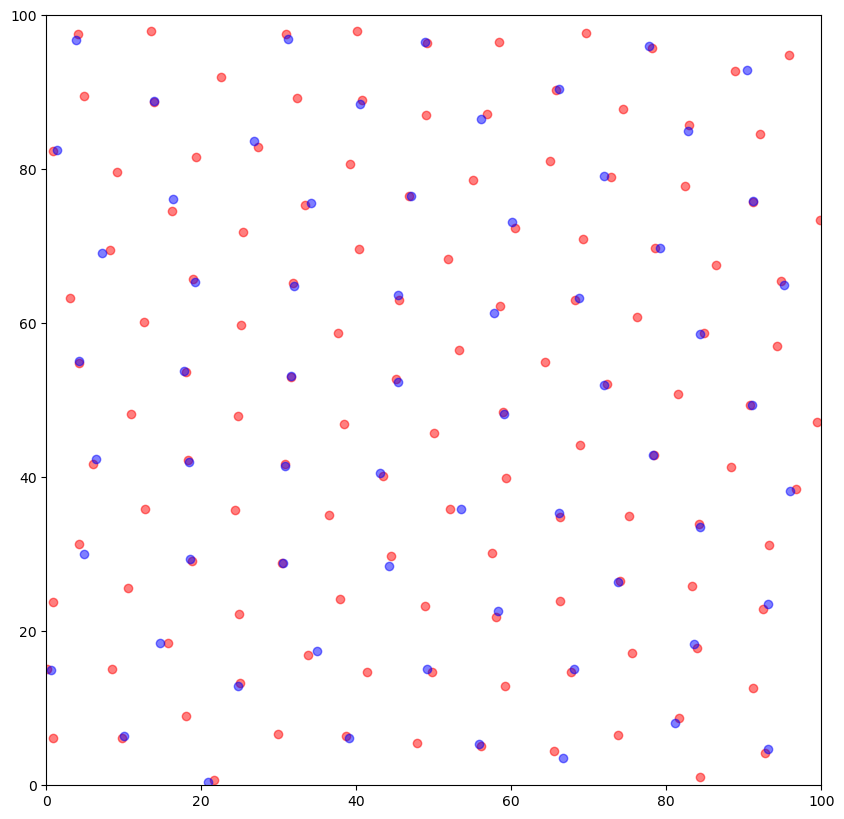

In [8]:
"""Visualize for Confirmation"""

positions = result[5][-1]
x1 = positions[:N1] % L_x
y1 = positions[N1:2 * N1] % L_y
x2 = positions[2 * N1: 2 * N1 + N2] % L_x
y2 = positions[2 * N1 + N2:] % L_y
plt.figure(figsize=(10, 10))
plt.scatter(x1, y1, color="red", alpha=0.5)
plt.scatter(x2, y2, color="blue", alpha=0.5)
plt.xlim(0, L_x)
plt.ylim(0, L_y)